# MBWU Evaluation

MBWU is 8581.875 ops/sec at thread number 58.


Text(0.5, 1.12, 'MBWU Evaluation Results')

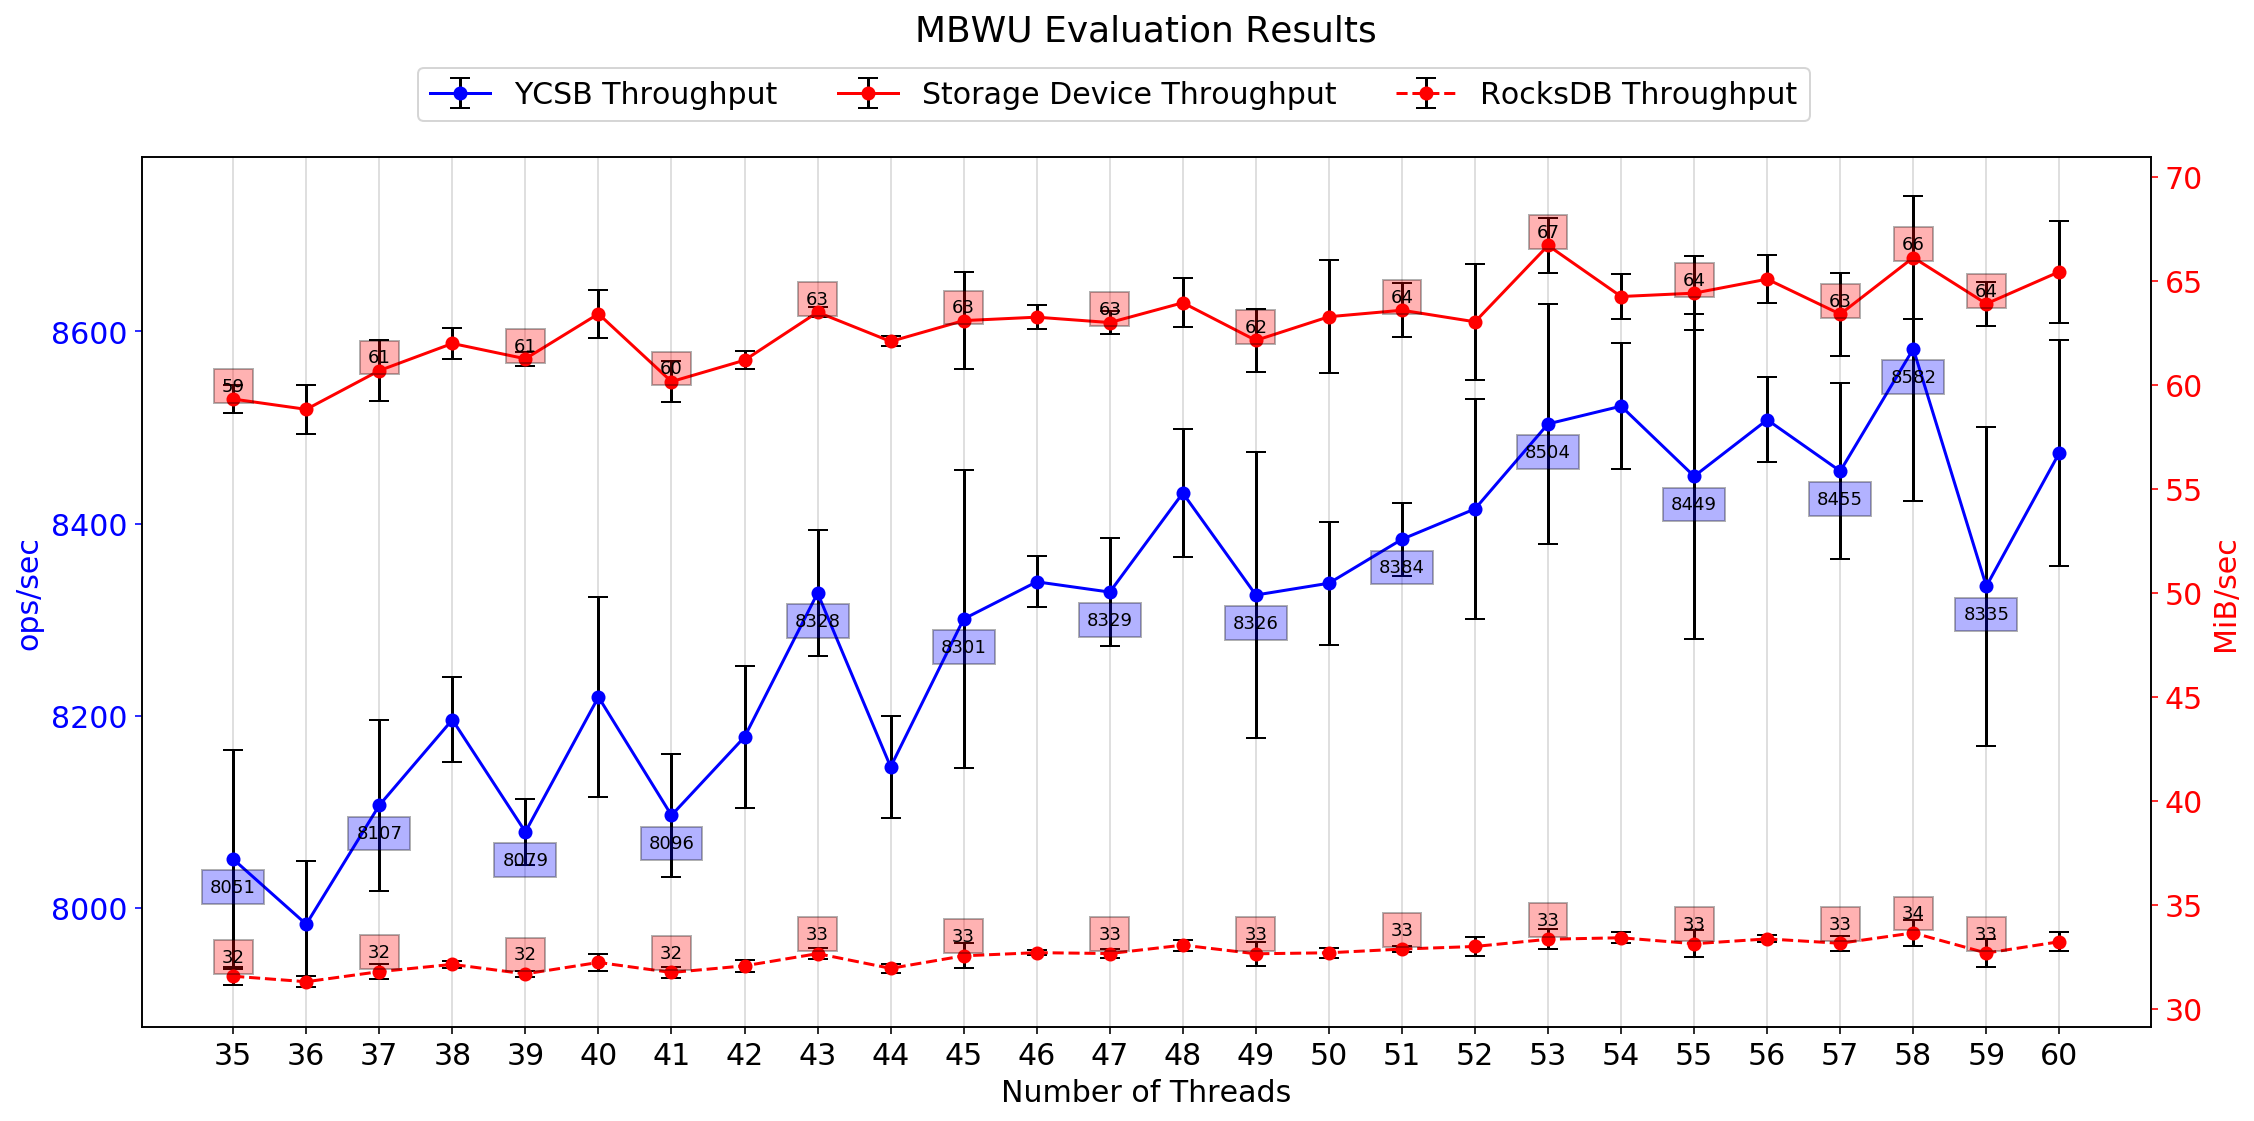

In [1]:
import json
import re
import requests
import os
import subprocess


# download script for parsing data
remote_script_url = 'https://raw.githubusercontent.com/ljishen/MBWU-RocksDB/master/scripts/get_thread_data.py'
local_script_file = '/tmp/' + os.path.basename(remote_script_url)

if not os.path.isfile(local_script_file):
    r = requests.get(remote_script_url, allow_redirects=True)
    with open(local_script_file, 'wb') as fd:
        fd.write(r.content)


DIR_BASE = 'data/ycsb/myworkloada/THNSNJ128G8NU/MBWU'
thread_folders = os.listdir(DIR_BASE)

data_points = {}

for folder in thread_folders:
    num_threads = int(re.search(r'(\d+)_threads', folder).group(1))

    process = subprocess.run(['python3', local_script_file, os.path.join(DIR_BASE, folder)],
                   capture_output=True, check=True, universal_newlines=True)
    data_points[num_threads] = json.loads(process.stdout)


# show data points
# print(data_points)

mbwu = sorted(data_points.items(), key=lambda kv: kv[1]['ycsb_throughput']['mean'])[-1]
print("MBWU is {:.3f} ops/sec at thread number {:d}.".format(mbwu[1]['ycsb_throughput']['mean'], mbwu[0]))

preserve_labels_at = [mbwu[0]]


# start to plot figure

##################  TEMPLATE  ##################

import matplotlib
import matplotlib.pyplot as plt

# Double resolution plot output for retina screens.
# Just be aware that this won’t render on non-retina screens.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.figsize'] = [18, 8]
matplotlib.rcParams["font.size"] = 15

fig, ax = plt.subplots()

def __update_color(bar):
    ax = bar.figure.gca()
    ax.tick_params(axis='y', colors=bar.get_color())
    ax.yaxis.label.set_color(bar.get_color())

def __autolabel(bar, verticalalignment='bottom'):
    """
    Attach a text label above each point displaying its value
    """
    ax = bar.figure.gca()

    yticks = ax.get_yticks()
    pos_delta = (yticks[1] - yticks[0]) * 0.1

    xydata = bar.get_xydata()

    global preserve_labels_at
    try:
        preserve_labels_at
    except NameError:
        preserve_labels_at = []

    for idx, xy in enumerate(xydata):
        if idx % 2 == 1 and xy[0] not in preserve_labels_at:
            continue

        height = xy[1]
        if verticalalignment == 'bottom':
            height += pos_delta
        elif verticalalignment == 'top':
            height -= pos_delta

        ax.text(xy[0], height,
                '%.0f' % xy[1],
                ha='center', va=verticalalignment, size=9,
                bbox=dict(facecolor=bar.get_color(), alpha=0.3))

##################  TEMPLATE  ##################


ax.set_ylabel('ops/sec')
ax.set_xlabel('Number of Threads')
ax.xaxis.grid(alpha=0.5)

xticks = sorted(data_points.keys())

ycsb_throughput_bar, *_ = ax.errorbar(
    xticks,
    [data_points[tick]['ycsb_throughput']['mean'] for tick in xticks],
    yerr=[data_points[tick]['ycsb_throughput']['stdev'] for tick in xticks],
    color='blue',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='YCSB Throughput')
__update_color(ycsb_throughput_bar)
__autolabel(ycsb_throughput_bar, 'top')


ax_mbs = ax.twinx()
ax_mbs.set_ylabel('MiB/sec')

device_throughput_bar, *_ = ax_mbs.errorbar(
    xticks,
    [data_points[tick]['device_mbs']['mean'] for tick in xticks],
    yerr=[data_points[tick]['device_mbs']['stdev'] for tick in xticks],
    color='red',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='Storage Device Throughput')
__update_color(device_throughput_bar)
__autolabel(device_throughput_bar)


_VALUE_SIZE_BYTES = 4 * 1024
_KEY_SIZE_BYTES = 16

factor = (_VALUE_SIZE_BYTES + _KEY_SIZE_BYTES) / 1024 / 1024

rocksdb_throughput_bar, *_ = ax_mbs.errorbar(
    xticks,
    [data_points[tick]['ycsb_throughput']['mean'] * factor for tick in xticks],
    yerr=[data_points[tick]['ycsb_throughput']['stdev'] * factor for tick in xticks],
    color='red',
    ls='--',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='RocksDB Throughput')
__update_color(rocksdb_throughput_bar)
__autolabel(rocksdb_throughput_bar)


fig.legend(loc="upper center",
           bbox_to_anchor=(0.5, 0.97),
           ncol=3,
           bbox_transform=fig.transFigure)
plt.xticks(xticks)
plt.title('MBWU Evaluation Results', y=1.12)